In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
# Read the CSV file
df = pd.read_csv('results.csv')

# Display basic information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326 entries, 0 to 1325
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   video_name            1326 non-null   object 
 1   scene_number          1326 non-null   int64  
 2   resolution            1326 non-null   object 
 3   square_size           1326 non-null   int64  
 4   percentage_to_remove  1326 non-null   float64
 5   alpha                 1326 non-null   float64
 6   neighbor_length       1326 non-null   int64  
 7   ref_stride            1326 non-null   int64  
 8   subvideo_length       1326 non-null   int64  
 9   bitrate               1326 non-null   int64  
 10  server_runtime        1326 non-null   int64  
 11  client_runtime        1326 non-null   int64  
 12  mse_ori_mean          1326 non-null   float64
 13  psnr_ori_mean         1326 non-null   float64
 14  ssim_ori_mean         1326 non-null   float64
 15  vmaf_ori_mean        

In [78]:
# scene number makes more sense as a string
df = df.astype({'scene_number': str})

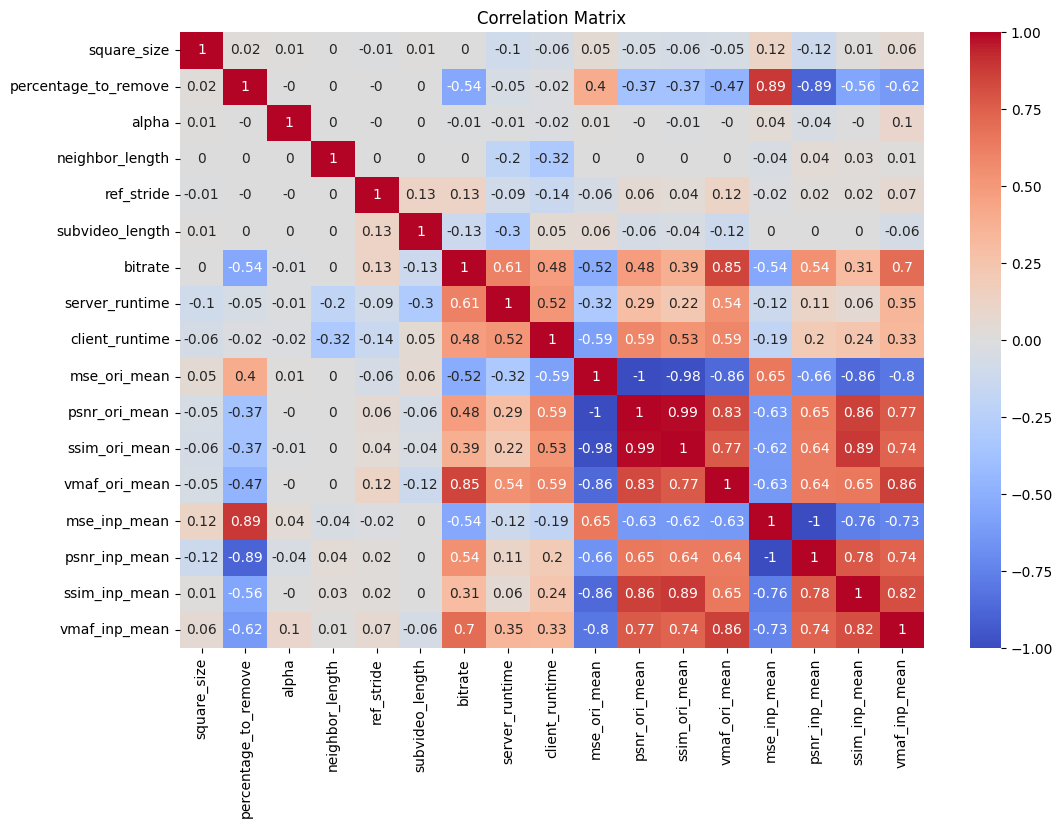

In [79]:
# Correlation matrix to see how parameters are related
correlation_matrix = df.corr('spearman', numeric_only=True)

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(np.round(correlation_matrix, 2), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

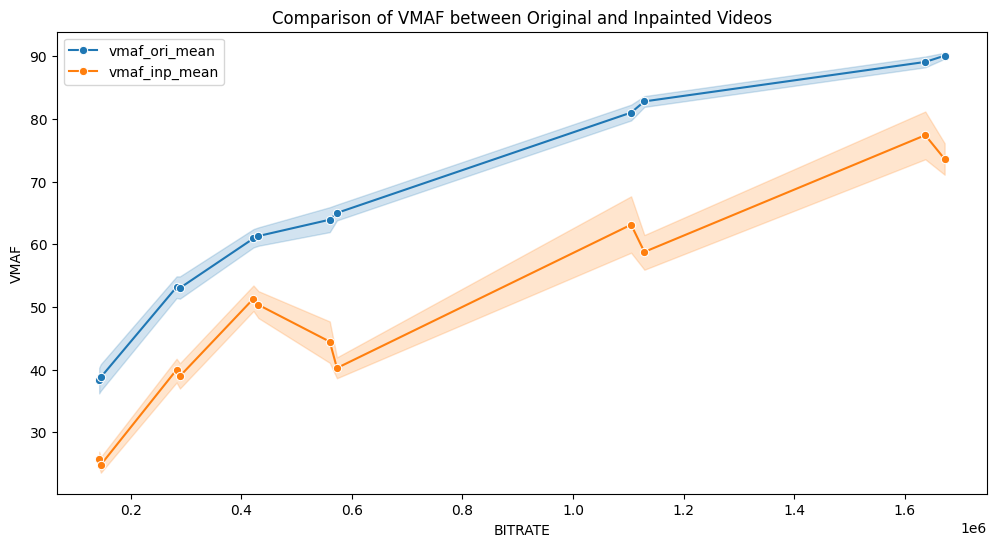

In [80]:
# Function to plot comparison between original and inpainted results
def plot_comparison(df, metric, parameter):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=parameter, y=f'{metric}_ori_mean', label=f'{metric}_ori_mean', marker='o')
    sns.lineplot(data=df, x=parameter, y=f'{metric}_inp_mean', label=f'{metric}_inp_mean', marker='o')
    plt.title(f'Comparison of {metric.upper()} between Original and Inpainted Videos')
    plt.xlabel(parameter.upper())
    plt.ylabel(metric.upper())
    plt.legend()
    plt.show()

# Plot comparisons for each metric
metrics = ['vmaf'] # 'mse', 'psnr', 'ssim'
parameters = ['bitrate'] # 'video_name', 'scene_number', 'resolution', 'square_size', 'percentage_to_remove', 'alpha', 'neighbor_length', 'ref_stride', 'subvideo_length', 'bitrate', 'server_runtime', 'client_runtime'
for metric in metrics:
    for parameter in parameters:
        plot_comparison(df, metric, parameter)

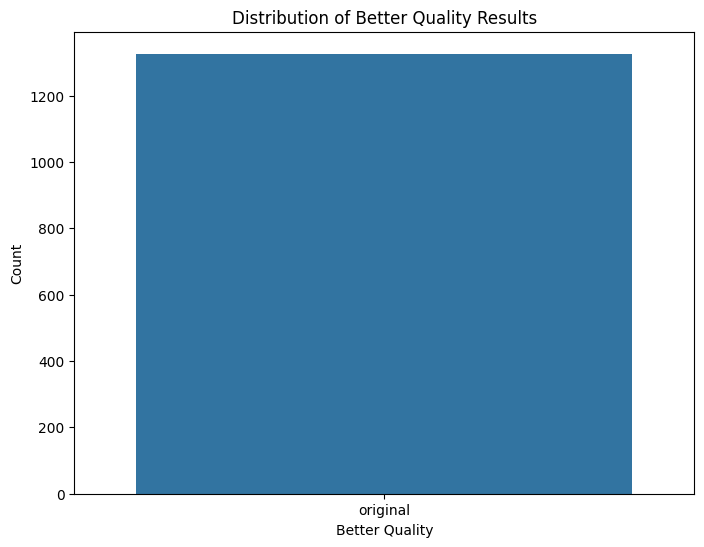

In [81]:
# Identify which scenes have better quality for original vs inpainted
df['better_quality'] = df.apply(lambda row: 'original' if row['vmaf_ori_mean'] > row['vmaf_inp_mean'] else 'inpainted', axis=1)

# Visualize the distribution of better quality results
plt.figure(figsize=(8, 6))
sns.countplot(x='better_quality', data=df)
plt.title('Distribution of Better Quality Results')
plt.xlabel('Better Quality')
plt.ylabel('Count')
plt.show()